$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge simulate$ $\hspace{0.1cm}$ $\Huge kSZ$ $\hspace{0.1cm}$ $\Huge maps$ $\hspace{0.1cm}$ $\Huge at$ $\hspace{0.1cm}$ $\Huge differents$ $\hspace{0.1cm}$ $\Huge frequencies$ $\hspace{0.1cm}$ $\Huge from$ $\hspace{0.1cm}$ $\Huge a$ $\hspace{0.1cm}$ $\Huge "y_{kSZ}"$ $\hspace{0.1cm}$ $\Huge map$ $\Huge :$ 

# Modules : 

In [5]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt 
from astropy import constants as cst
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
from astropy.io import fits
from astropy import units as u
import pysm as pysm
import ccatp_sky_model as sky
from astropy.cosmology import FlatLambdaCDM

In [6]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value

In [7]:
data_path = "/vol/arc3/data1/sz/CCATp_sky_model/templates/"

# Functions : 

###### General informations on kSZ : 

The equation to convert between a change in intensity ($\Delta I$) and a change of Temperature ($\Delta T_{CMB}$) is : 

$\frac{\Delta I}{\Delta T_{CMB}}=\frac{I_0}{T_{CMB}}\frac{x^{4}e^{x}}{(e^{x}-1)^{2}}$ or $\Delta I=-I_{0}y_{kSZ}\frac{x^{4}e^{x}}{(e^{x}-1)^{2}}$ with $y_{kSZ}=1$

Then to go from a map in Jysr$^{-1}$ to a map in $\mu K$ we need to multiply the maps by the INVERSE of : 

$\Delta T_{CMB} = \frac{T_{CMB}\times 10^{6}\Delta I}{I_0\times 10^{26}}\frac{(e^{x}-1)^{2}}{x^{4}e^{x}}$

$I_0\times 10^{20}=270.33$ is converted from [MJy/sr] to [Jy/sr] by multiplying by $10^{6}$. To get the maps in $\mu K$, we multiply $T_{CMB}$ [K] by $10^{6}$ also. 

###### Sehgal kSZ : 

$T_{CMB}$ is the temperature of the CMB. To get the proper kSZ map we can use for our study, we need to divide each kSZ map at a given frequency by a given vector, which will turn the Jysr$^{-1}$ map into a $\frac{\Delta T}{T_{CMB}}$ map which is dimensionless. To get a map in $\mu K$, we need to multiply by $T_{CMB}\times 10^{6}$

In [10]:
def simulate_kSZ(freq, nside_out = 4096, lmax = None, beam_FWHM = None, template = "SO", unit = "cmb"):

    """
    Function which computes kSZ maps at different frequencies and different nside. 
    
    Parameters
    ----------
    freq: float or float array
        Frequency of the output map in Hz.
    nside_out: float
        Healpix nside parameter of the output map. Must be a valid value for nside.
        Default: 4096
    lmax: float
        Maximum value of the multipolemoment at which the atmospheric power spectrum
        wil be computed. Default: 3*nside_out-1            
    beam_FWHM: bool, optional
        If set, the output will be convolved with a gaussian. The FWHM of the Gaussian
        in units of arcmin is given by the provided value. Default: None
    template: bool, optional
        Determines the all-sky foregrounds templates to be used to build the sky model.
        If 'Sehgal' is chosen, simulations by Sehgal et al. (2010) are used.
        If 'SO' is chosen, the Simons Observatory sky model provided by Colin Hill and 
        based on the simulations by Sehgal et al. (2010) is used. If 'CITA' is chosen,
        the used templates will be based on the WebSky Extragalactic CMB Mocks provided 
        by CITA. Default: 'SO'
    unit: bool, optional
        Determines the units of the output map. The available units are 'mjy' --> MJy/sr
        (specific intensity), 'cmb' --> K_CMB (thermodynamic temperature), and 
        'rj' --> K_RJ (brightness temperature). Default: 'cmb'.
        
    Returns
    -------
    kSZ: float array
        Healpy all-sky map contaning the kSZ map at a given frequency. 
    """

    #Read data
    if template != "SO" and template != "CITA" and template != "Sehgal":
        print("Waring: Unknown template requested! Output will be based on SO sky model")
        template = "SO"

    if template == 'SO':
        
        file_in = 'kSZ/148_ksz_healpix_nopell_Nside4096_DeltaT_uK.fits'
        kSZ = hp.read_map(data_path + file_in, dtype = np.float32)/1e6
        
    elif template == 'CITA':
        
        file_in = 'kSZ/ksz.fits'
        kSZ = hp.read_map(data_path + file_in, dtype = np.float32)/1e6
        
    elif template == 'Sehgal' : 
              
        file_in = 'kSZ/030_ksz_healpix.fits'  
        kSZ = hp.read_map(data_path + file_in, dtype = np.float32) * convert_units(30e9, 1e-6, mjy2cmb=True)
 
    #Re-bin map if necessary
    if hp.get_nside(kSZ) != nside_out:
        kSZ = hp.pixelfunc.ud_grade(kSZ, nside_out = nside_out)

    #Smooth map if necessary
    if beam_FWHM is not None:
        print("begin smoothing")
        kSZ = hp.sphtfunc.smoothing(kSZ, iter = 0, lmax = lmax, fwhm = beam_FWHM/60*np.pi/180)

    #Convert units if necessary
    if unit == "mjy":
        kSZ = convert_units(freq, kSZ, cmb2mjy=True)
    elif unit == "cmb":
        None
    elif unit == "rj":
        kSZ = convert_units(freq, kSZ, cmb2rj=True)
    else:
        print("Waring: Unknown unit! Output will be in K_CMB")

    return(kSZ)

# Launch and display : 

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


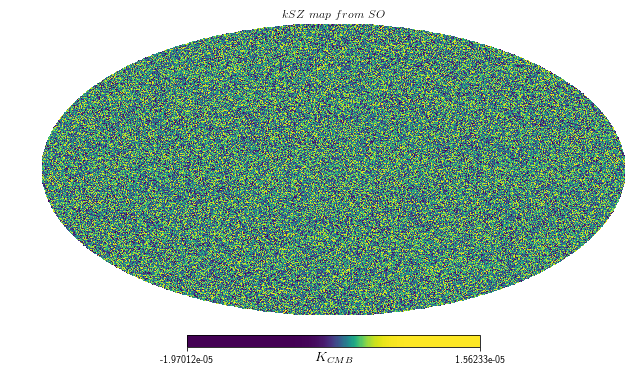

In [11]:
kSZ = simulate_kSZ(30e9, nside_out = 4096, lmax = None, beam_FWHM = None, template = "SO", unit = "cmb")

#Display map The kSZ map : 
hp.mollview(kSZ, title="$kSZ$ $map$ $from$ $SO$", norm='hist',unit='$K_{CMB}$')